# Analyzing simple weather data 
**Objective**: 

- Summarize weather patterns by city and season to support high-level operational planning.
- Identify time periods or cities with extreme or volatile weather conditions that may affect public services or infrastructure readiness.
- Detect trends and shifts in climate patterns using rolling averages and seasonal decomposition.
- Explore relationships between temperature, humidity, wind, and precipitation to uncover potential drivers of extreme conditions.
- Present insights visually and narratively in a way that is clear, accessible, and decision-focused.

**Dataset(s)**: 

Found on Kaggle ([source](https://www.kaggle.com/datasets/prasad22/weather-data)), this dataset contains 1 million records in a 99 MB `CSV` file. 

The data recorded is location, date and time, temperature, humidity, precipitation, and wind speed.

**Tools Used**:

Python
- pandas
- matplotlib
- numpy
- seaborn

## 1. Introduction

This project explores a fictional dataset containing weather measurements across multiple cities, including temperature, humidity, precipitation, wind speed, and timestamped records. The goal is to simulate a real-world data analysis workflow that supports actionable insights for stakeholders, such as city planners, business operators, or logistics managers.

Through this project, I demonstrate core competencies in exploratory data analysis (EDA), time-series analysis, data visualization, and stakeholder-style reporting. Emphasis is placed on identifying temporal trends, geographic differences, extreme events, and meaningful correlations between weather variables.

In [39]:
# Add the project root to sys.path
import sys
import os
sys.path.append(os.path.abspath(".."))

# Import packages and variables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from os.path import join
from IPython.display import HTML
from projectconfig.config import raw_data_path, processed_data_path, data_dir

# Visualization settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## 2. Data Understanding

In [40]:
# Load data
df = pd.read_csv(raw_data_path, parse_dates=['Date_Time'])

# Preview data
df.head()

,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
0,San Diego,2024-01-14 21:12:46,10.683001,41.195754,4.020119,8.233540
1,San Diego,2024-05-17 15:22:10,8.734140,58.319107,9.111623,27.715161
2,San Diego,2024-05-11 09:30:59,11.632436,38.820175,4.607511,28.732951
3,Philadelphia,2024-02-26 17:32:39,-8.628976,54.074474,3.183720,26.367303
4,San Antonio,2024-04-29 13:23:51,39.808213,72.899908,9.598282,29.898622


In [41]:
# Structure and summary
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Location          1000000 non-null  object        
 1   Date_Time         1000000 non-null  datetime64[ns]
 2   Temperature_C     1000000 non-null  float64       
 3   Humidity_pct      1000000 non-null  float64       
 4   Precipitation_mm  1000000 non-null  float64       
 5   Wind_Speed_kmh    1000000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 45.8+ MB


,Location,Date_Time,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh
count,1000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
unique,10,NaN,NaN,NaN,NaN,NaN
top,Phoenix,NaN,NaN,NaN,NaN,NaN
freq,100209,NaN,NaN,NaN,NaN,NaN
mean,NaN,2024-03-10 10:40:58.896321792,14.779705,60.021830,5.109639,14.997598
min,NaN,2024-01-01 00:00:06,-19.969311,30.000009,0.000009,0.000051
25%,NaN,2024-02-04 16:28:23.750000128,2.269631,45.008500,2.580694,7.490101
50%,NaN,2024-03-10 11:43:28,14.778002,60.018708,5.109917,14.993777
75%,NaN,2024-04-14 03:51:32.500000,27.270489,75.043818,7.613750,22.514110
max,NaN,2024-05-18 19:44:10,39.999801,89.999977,14.971583,29.999973


### Summary

There does not seem to be any obvious issues with the data.

The data types make sense.

None of the records are missing any column values and the ranges of values found in each of the numeric columns appear to have no unusual or impossible values.

One thing that is interesting to note is that the mean and median for each numeric column is nearly identical. In a real-world situation, I think that would require closer scrutiny, as perfectly symmetrical weather data seems unlikely.

## 3. Data Cleaning & Preparation

In [42]:
# Rename columns to ease use
names = {
    'Location': 'location',
    'Date_Time': 'datetime',
    'Temperature_C': 'temperature',
    'Humidity_pct': 'humidity',
    'Precipitation_mm': 'precipitation',
    'Wind_Speed_kmh': 'windspeed'
}
df.rename(inplace=True, columns=names)
print(df.dtypes)


location                 object
datetime         datetime64[ns]
temperature             float64
humidity                float64
precipitation           float64
windspeed               float64
dtype: object


In [45]:
# Check for duplicate records
duplicates = df[df.duplicated(subset=['location', 'datetime'], keep=False)].sort_values(['location', 'datetime'])
display(duplicates)
duplicates.to_csv(join(data_dir, 'duplicates.csv')) # export to data file 'duplicates.csv'
print('Number of duplicate records: ', duplicates.shape[0])
print(duplicates.location.value_counts())

,location,datetime,temperature,humidity,precipitation,windspeed
138002,Chicago,2024-01-01 05:42:05,33.885939,51.196421,7.223224,23.560251
515729,Chicago,2024-01-01 05:42:05,-5.311788,79.611929,6.933497,2.759744
862891,Chicago,2024-01-01 06:56:45,0.861692,88.027134,3.701042,13.913699
875558,Chicago,2024-01-01 06:56:45,6.179934,86.207245,7.995065,16.488742
121537,Chicago,2024-01-01 08:15:35,0.224201,58.737580,8.984158,17.326420
...,...,...,...,...,...,...
991281,San Jose,2024-05-17 07:00:25,11.620164,61.997047,5.733704,28.898879
290407,San Jose,2024-05-18 06:18:47,13.168688,68.561387,5.019403,2.469587
770840,San Jose,2024-05-18 06:18:47,-1.436935,34.615755,2.212580,18.361293
68786,San Jose,2024-05-18 15:49:49,31.410860,58.393864,6.866484,12.475861


Number of duplicate records:  8221
location
Philadelphia    871
San Diego       867
Phoenix         861
Chicago         838
San Jose        838
Los Angeles     819
San Antonio     797
Houston         795
New York        791
Dallas          744
Name: count, dtype: int64


In [37]:
# Calculate means for duplicated records
dup_mean = duplicates.groupby(['location', 'datetime']).agg('mean').reset_index()
display(dup_mean)
assert dup_mean.duplicated().sum() == 0

,location,datetime,temperature,humidity,precipitation,windspeed
0,Chicago,2024-01-01 05:42:05,14.287075,65.404175,7.078361,13.159997
1,Chicago,2024-01-01 06:56:45,3.520813,87.117190,5.848053,15.201221
2,Chicago,2024-01-01 08:15:35,14.079050,55.971951,5.288224,14.534819
3,Chicago,2024-01-01 19:52:32,21.151036,84.403052,4.856620,20.331755
4,Chicago,2024-01-01 21:15:26,8.155716,48.033175,3.037764,13.169007
...,...,...,...,...,...,...
4095,San Jose,2024-05-15 19:05:54,-3.509830,60.698656,4.022879,14.015743
4096,San Jose,2024-05-16 11:15:29,13.743265,79.665237,7.654933,13.141986
4097,San Jose,2024-05-17 07:00:25,6.087132,73.142743,5.941712,18.497535
4098,San Jose,2024-05-18 06:18:47,5.865877,51.588571,3.615991,10.415440


In [38]:
# Drop duplicates and concatenate unique records with calculated means 
df_dropped = df.drop_duplicates(['location', 'datetime'], keep=False)
df = pd.concat([df_dropped, dup_mean])
df.reset_index(drop=True, inplace=True)
df.sort_values(['datetime', 'location'], inplace=True) # sort by datetime
display(df)
assert df.duplicated().sum() == 0
df.to_csv(join(data_dir, 'processed_weather.csv'), index=False)

,location,datetime,temperature,humidity,precipitation,windspeed
683438,Houston,2024-01-01 00:00:06,39.469465,34.789904,9.807685,20.475434
357781,Phoenix,2024-01-01 00:00:06,0.618582,46.871717,7.379615,5.321995
877302,Los Angeles,2024-01-01 00:00:15,35.920611,80.786237,0.859060,21.634439
623668,San Antonio,2024-01-01 00:00:18,32.048197,45.576250,2.894071,23.335641
700535,San Diego,2024-01-01 00:00:31,-8.090262,81.472454,5.435076,7.609853
...,...,...,...,...,...,...
977208,Chicago,2024-05-18 19:43:30,-1.561114,35.861711,8.802004,7.852678
214633,Philadelphia,2024-05-18 19:43:50,8.597967,88.073644,5.137802,21.671935
322076,New York,2024-05-18 19:43:55,7.679884,89.701606,6.760624,21.417264
802993,Houston,2024-05-18 19:44:02,34.038278,57.755329,0.939044,4.530607


### Summary

- I renamed the columns to make working with the data (a little) easier.
- There are no missing values.
- The data type for each column is appropriate and optimal for analysis.
- There are 4121 duplicated rows, based on "location" and "datetime". Because this is synthetic data generated from reasonable ranges in each location for a given time of year, I replaced the duplicate records with a single record which averaged the values of the duplicates. I then sorted the final product by date and time.

## 4. Exploratory Data Analysis (EDA)
- Distribution of variables
- Relationships between key features
- Business questions explored

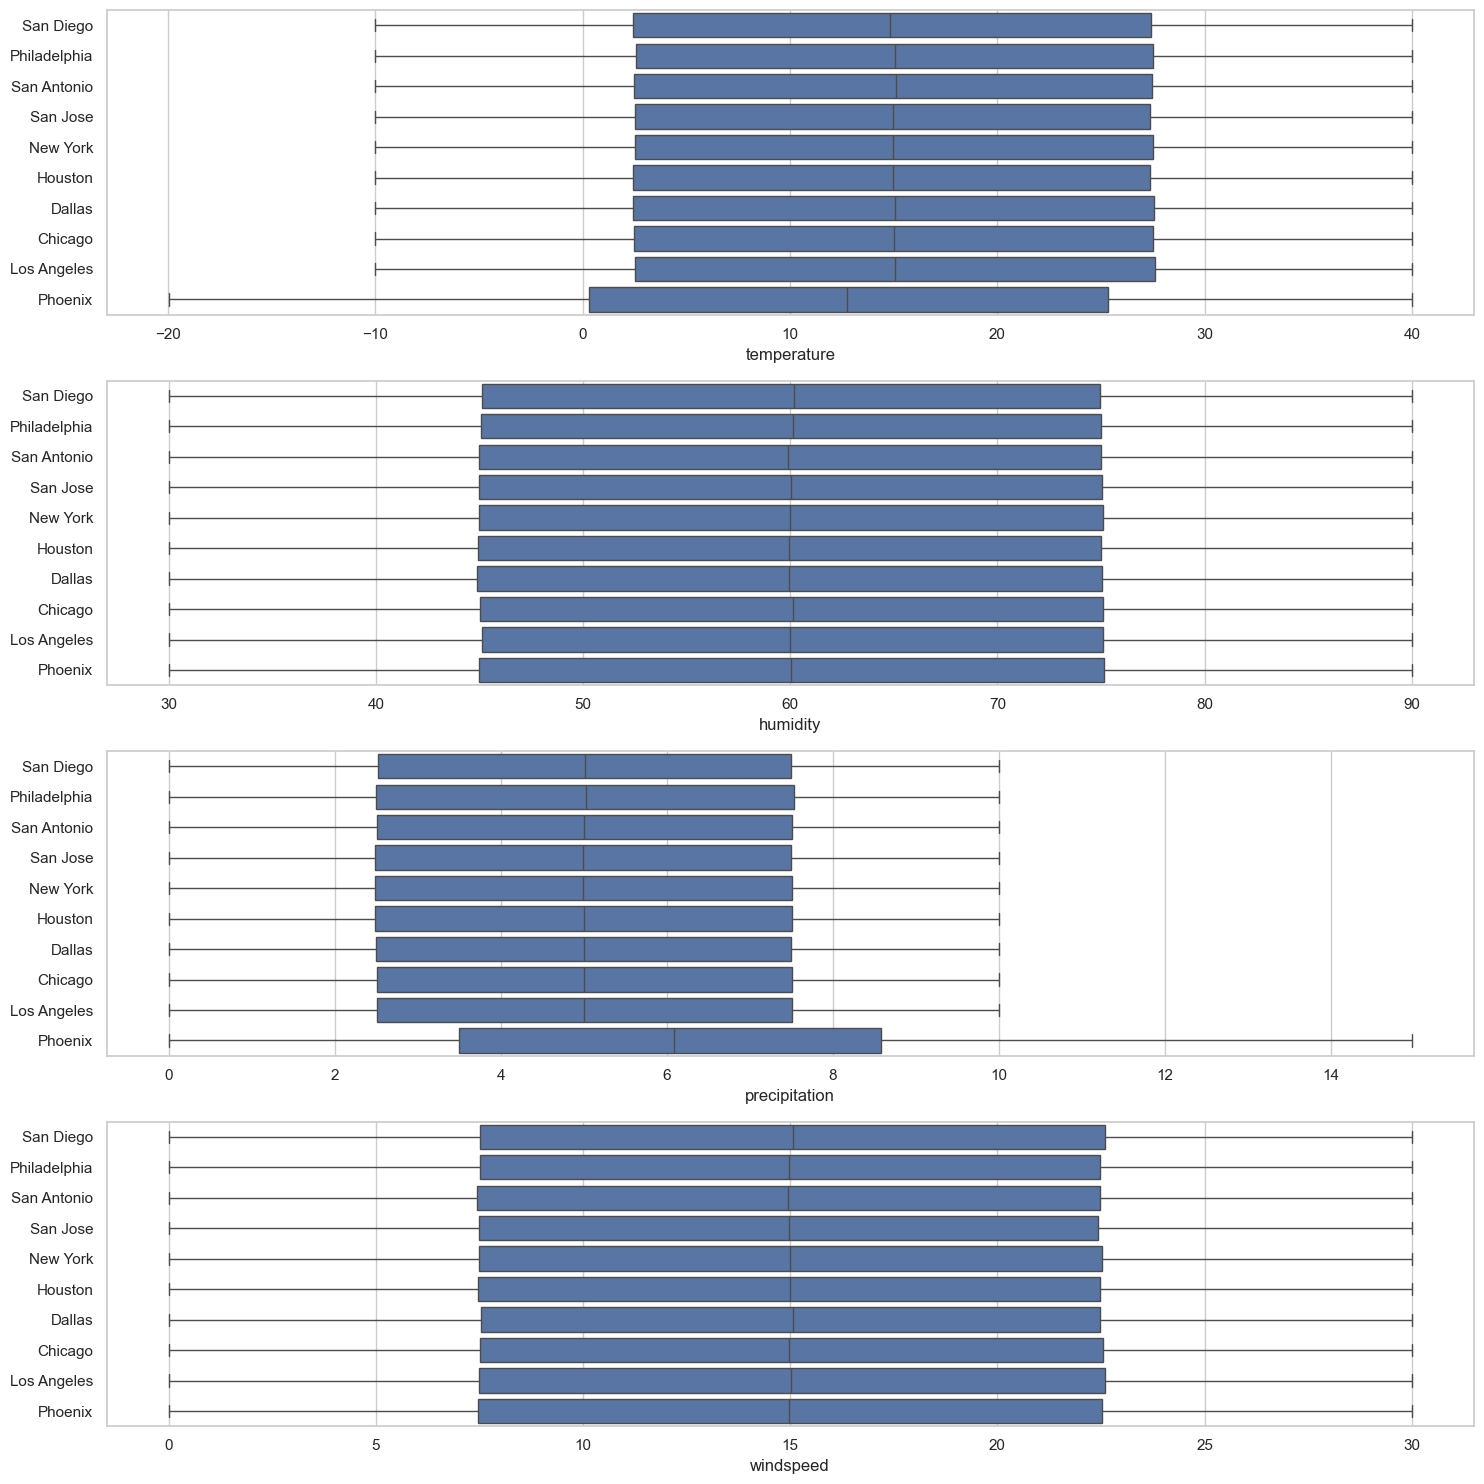

In [47]:
# Temperature
cols = [c for c in df.columns if c not in ['location', 'datetime']]
fig, axes = plt.subplots(len(cols), 1, figsize=(15,15))
la = zip(cols, axes)
for l, a in la:
    sns.boxplot(df, x=l, y='location', ax=a)
    a.set_ylabel('')
plt.tight_layout()

Note:
There seems to be something unusual with Phoenix's data: it's distibution for "temperature" and "precipitation" contains values well outside of the physical norm. Also, Phoenix seems to be the odd one out when compared to other cities in terms of temperature and precipitation.

Additionally, these values seem pretty similar for cities that exist in very different climes (e.g. San Diego, CA and Chicago, IL).

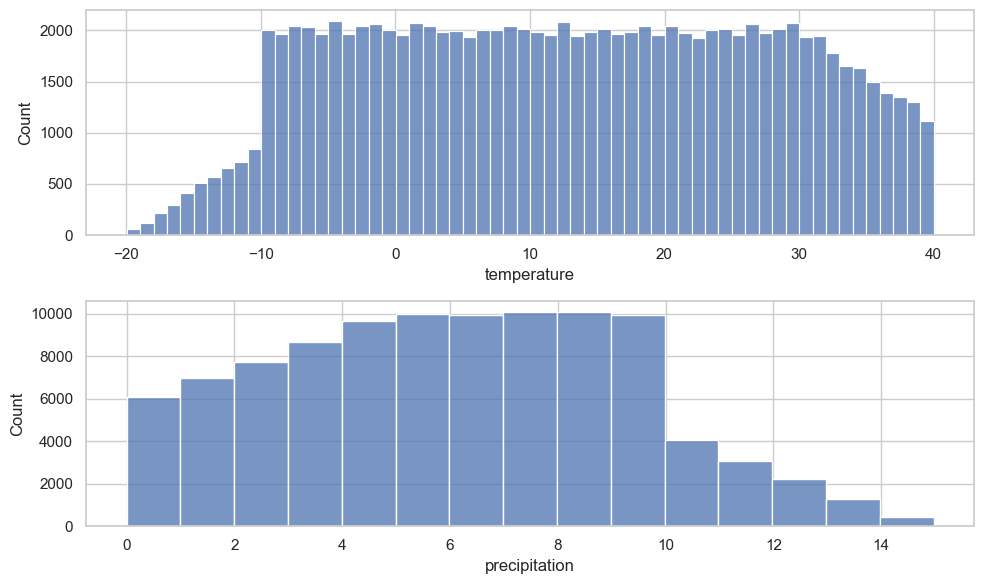

In [48]:
# Examine the distribution shape of Phoenix's temperature and precipitation data
df_phoenix = df.loc[df.location == 'Phoenix']
cols = ['temperature', 'precipitation']
fig, axes = plt.subplots(nrows=2)
la = zip(cols, axes)
for c, a in la:
    sns.histplot(df_phoenix, x=c, ax=a, binwidth=1)
plt.tight_layout()

Phoenix has some odd distibutions for these variables. I want to see how it compares to other "locations".

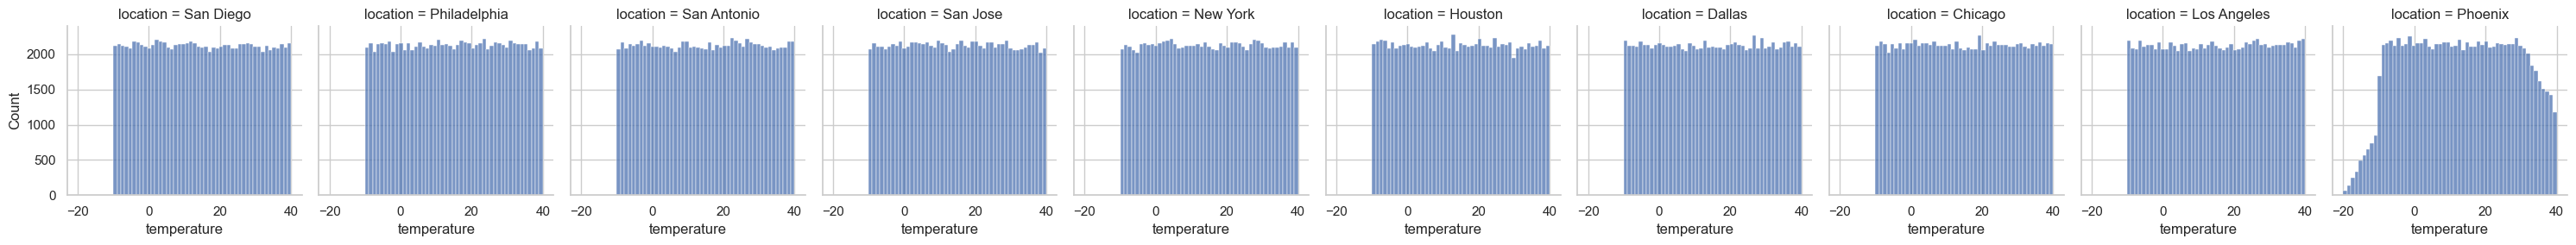

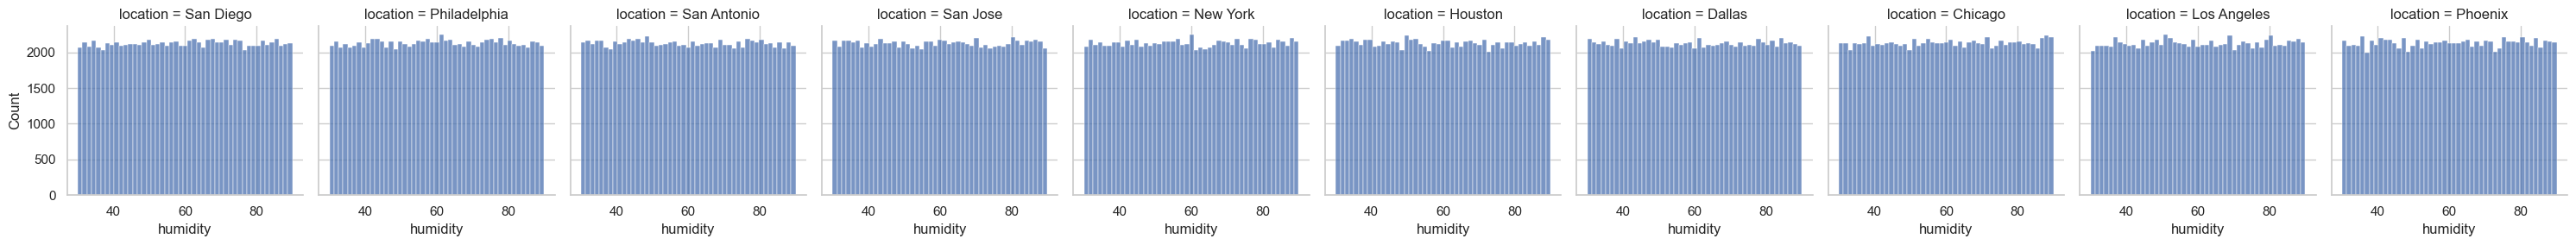

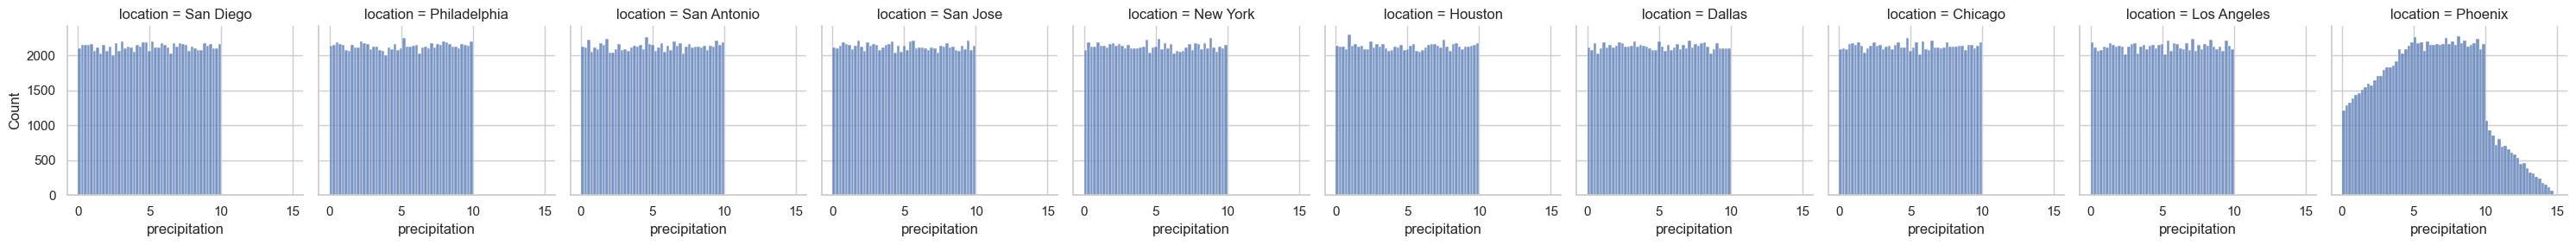

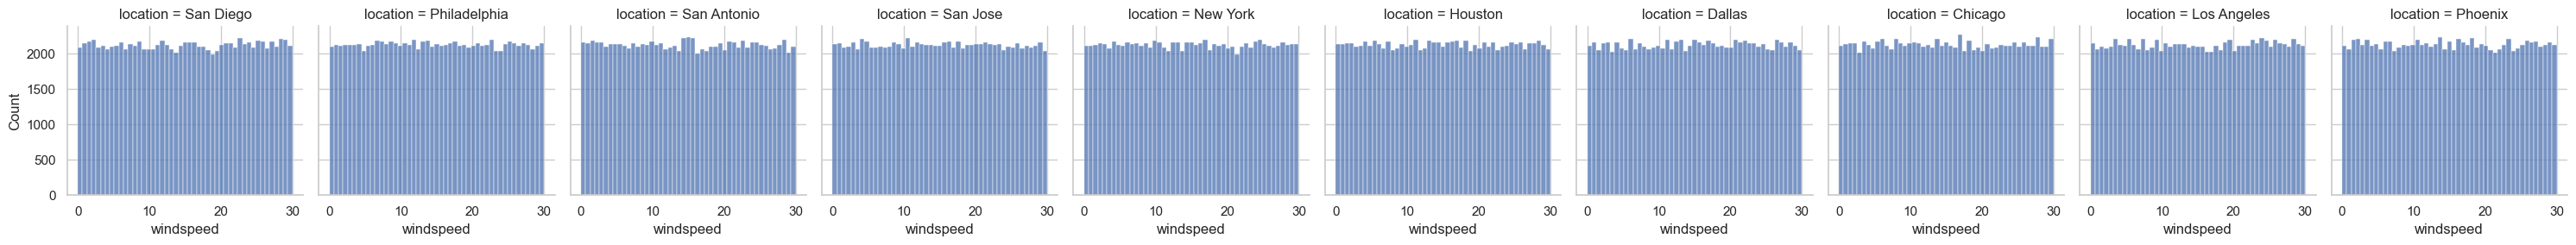

In [52]:
# Examine the distribution shape of all locations' temperature and precipitation data
cols = ['temperature', 'humidity', 'precipitation', 'windspeed']
for c in cols:
    g = sns.FacetGrid(df, col='location')
    g.map(sns.histplot, c)
plt.show()

Most "locations" have a similar uniform distribution for the weather variables.
Phoenix is the odd one out, possessing many values below -10 degrees and many values above 10 mm of precipitation and missing values below 5 mm precipitation, relative to other "locations".

In [50]:
# Example EDA
sns.histplot(df['target_variable'])
plt.title('Distribution of Target Variable')
plt.show()

KeyError: 'target_variable'

In [ ]:
# Correlation heatmap
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

## 5. Deeper Analysis or Modeling
- Trend analysis, segment analysis, KPIs
- Simple models if needed
- Explain business implications of findings

In [ ]:
# Example: Customer churn by segment
df.groupby('segment')['churn'].mean().sort_values(ascending=False)

## 6. Insights & Recommendations
- 🔹 Insight 1: ...
- 🔹 Insight 2: ...
- 🔹 Insight 3: ...
- ✅ Recommended Actions:
    - ...
    - ...

## 7. Conclusion
- Recap of goals and findings
- Limitations
- Suggestions for future work

## 8. Appendix
- Additional charts
- Definitions
- Notes on calculations